In [9]:
import pandas as pd
import scirpy as ir

def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

def donor_colors():
    donors = ['TSP1','TSP2','TSP3','TSP4','TSP5','TSP6','TSP7','TSP8','TSP9','TSP10','TSP11','TSP12','TSP13','TSP14','TSP15']
    
    import matplotlib.colors as pltcolors
    
    cmap = plt.cm.get_cmap("YlGnBu")
        
    donor_color_dict = {}
    j=1/len(donors)
    for d in donors:
        donor_color_dict[d] = pltcolors.to_hex(cmap(j))
        j+=1/len(donors)
        
    return donor_color_dict


def donor_colors():
    donor_color_dict = {'TSP6': '#034001', 'TSP7': '#8FBC8F', 'TSP4': '#c5ba30', 'TSP5': '#DC143C', 
                    'TSP10': '#FFD700', 'TSP8': '#8839ff', 'TSP3': '#c34a17', 'TSP11': '#00edff', 
                    'TSP12': '#f507a0', 'TSP9': '#9CADCA', 'TSP14': '#27BFD2', 'TSP15': '#bc7c00', 
                    'TSP1': '#4169E1', 'TSP2': '#636c8c', 'TSP13': '#ADD8E6'}
    return donor_color_dict

metadata = '../../metadata/TSP1_TSP15_metadata.csv'
airr_formatted = '../../data/processed_data/airr_formatted.tsv'

/tmp/ipykernel_7814/633492012.py:4: FutureWarning: chain_pairing is a deprecated function and will be removed in a future version of scirpy. Use `tl.chain_qc` instead.
  ir.tl.chain_pairing(adata)
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'receptor_type' as categorical
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'recepto

single pair        5595
orphan VJ          2310
orphan VDJ         1737
extra VJ            453
ambiguous           168
extra VDJ            98
two full chains      47
multichain           18
Name: chain_pairing, dtype: int64


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [143757, 144258, 144244, 143761, 144159]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


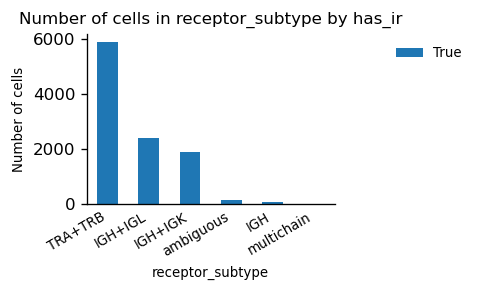

In [2]:
adata = ir.io.read_airr(airr_formatted, include_fields=('productive', 'sequence', 'locus', 'v_call', 'd_call', 'j_call', 'c_call', 'junction', 'junction_aa', 'consensus_count', 'duplicate_count', 'v_mu_freq'))

ir.tl.chain_qc(adata)
ir.tl.chain_pairing(adata)

print(adata.obs.chain_pairing.value_counts())
ax = ir.pl.group_abundance(adata, groupby='receptor_subtype')


# metadata from h5ad
met = pd.read_csv(metadata)
met[(met.donor == "TSP1") & (met.method == 'smartseq2')].cell_id.str.rsplit(".", n = 5, expand = True)[0]
met['_cell_id'] = met['cell_id']
met['_cell_id'] = met['_cell_id'].str.replace('_[0-2]_[0-2]_5prime', '_5prime', regex = True)
met['_cell_id'] = met['_cell_id'].str.replace('.homo.gencode.v30.ERCC.chrM', '', regex = True)

merged = pd.merge(adata.obs, met, how = 'inner', left_on='cell_id', right_on='_cell_id')

adata = adata[adata.obs.index.isin(merged.cell_id)]

adata.obs = pd.merge(adata.obs, met, how = 'inner', left_index=True, right_on='cell_id')

adata.obs.index = adata.obs.cell_id

#ir.pp.ir_dist(adata, metric="alignment", sequence='aa')

#ir.tl.define_clonotypes(adata, key_added='clone_id')


In [3]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")

100%|██████████████████████████████████████████████████| 4488/4488 [00:02<00:00, 1545.57it/s]


In [4]:
ir.tl.clonotype_network(adata, min_cells=5)


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue' as categorical
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is depre

<AxesSubplot:>

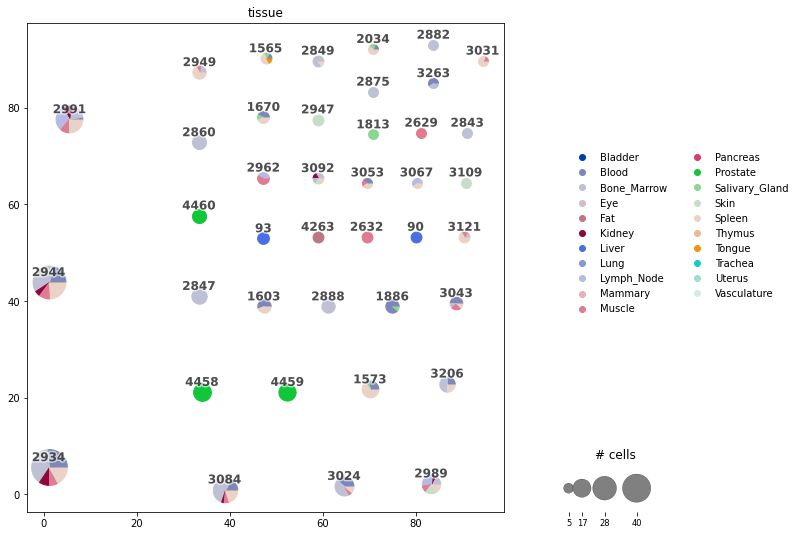

In [5]:
ir.pl.clonotype_network(
    adata, color="tissue", base_size=20, label_fontsize=12, panel_size=(9, 9)
)

<AxesSubplot:>

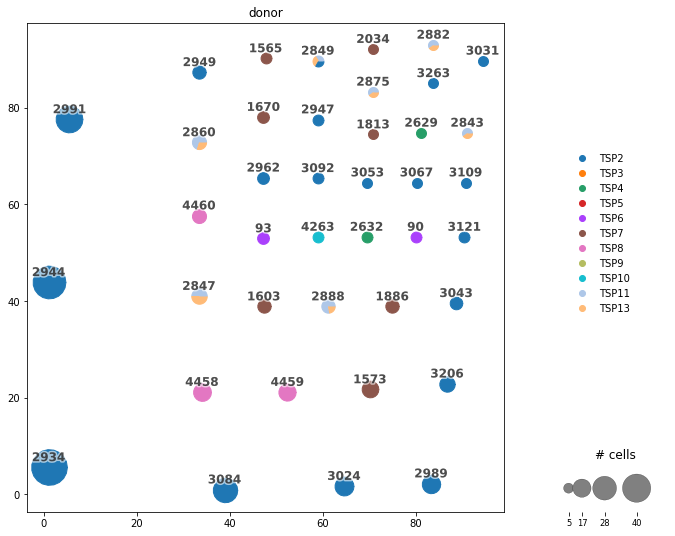

In [6]:
ir.pl.clonotype_network(
    adata, color="donor", base_size=20, label_fontsize=12, panel_size=(9, 9)
)

In [17]:
# investigating prostate privacy
pd.set_option("display.max_rows", None, "display.max_columns", None)
adata.obs.groupby(['tissue', 'donor']).count()

multi_chain  extra_chains  IR_VJ_1_c_call  \
tissue         donor                                              
Bladder        TSP2             9             9               0   
               TSP3             0             0               0   
               TSP4             0             0               0   
               TSP5             0             0               0   
               TSP6             0             0               0   
               TSP7             0             0               0   
               TSP8             0             0               0   
               TSP9             0             0               0   
               TSP10            0             0               0   
               TSP11            0             0               0   
               TSP13            0             0               0   
Blood          TSP2           334           334               0   
               TSP3             0             0               0   
               TSP4             0             0               0   
               TSP5             0             0               0   
               TSP6             0             0               0   
               TSP7           138           138               0   
               TSP8             0             0               0   
               TSP9             0             0               0   
               TSP10            0             0               0   
               TSP11            0             0               0   
               TSP13            0             0               0   
Bone_Marrow    TSP2           229           229               0   
               TSP3             0             0               0   
               TSP4             0             0               0   
               TSP5             0             0               0   
               TSP6             0             0               0   
               TSP7             0             0               0   
               TSP8             0             0               0   
               TSP9             0             0               0   
               TSP10            0             0               0   
               TSP11          347           347               0   
               TSP13          140           140               0   
Eye            TSP2             0             0               0   
               TSP3            70            70               0   
               TSP4             0             0               0   
               TSP5            47            47               0   
               TSP6             0             0               0   
               TSP7             0             0               0   
               TSP8             0             0               0   
               TSP9             0             0               0   
               TSP10            0             0               0   
               TSP11            0             0               0   
               TSP13            0             0               0   
Fat            TSP2             0             0               0   
               TSP3             0             0               0   
               TSP4             0             0               0   
               TSP5             0             0               0   
               TSP6             0             0               0   
               TSP7             0             0               0   
               TSP8             0             0               0   
               TSP9             0             0               0   
               TSP10          172           172               0   
               TSP11            0             0               0   
               TSP13            0             0               0   
Kidney         TSP2           103           103               0   
               TSP3             0             0               0   
               TSP4             0             0               0   
  

In [ ]:
## Recompute the clonal relationships based on CDRs

In [29]:
ir.pp.ir_dist(
    adata,
    metric="alignment",
    sequence="aa",
    cutoff=10,
)

100%|███████████████████████████████████████████████████| 2278/2278 [00:11<00:00, 194.03it/s]


In [30]:
ir.tl.define_clonotype_clusters(
    adata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)


100%|███████████████████████████████████████████████████| 4476/4476 [00:07<00:00, 597.45it/s]


In [31]:
ir.tl.clonotype_network(adata, min_cells=5, sequence="aa", metric="alignment")


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cc_aa_alignment' as categorical


<AxesSubplot:>

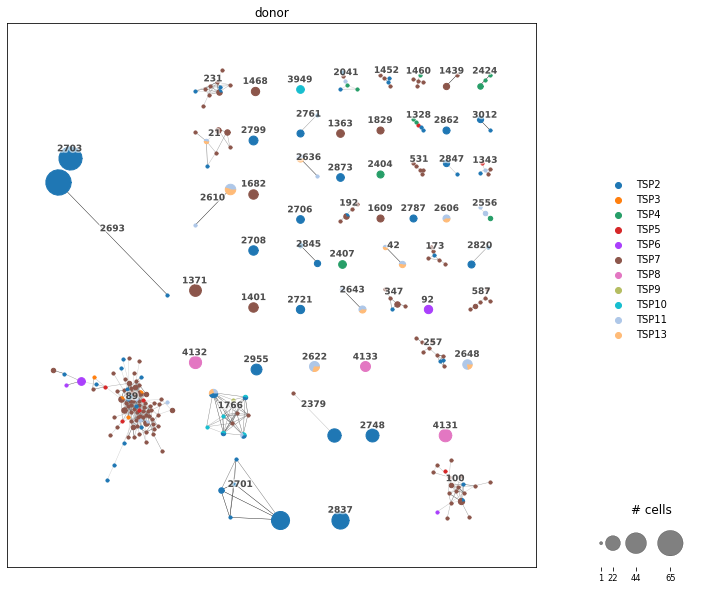

In [32]:
ir.pl.clonotype_network(
    adata, color="donor", label_fontsize=9, panel_size=(10, 10), base_size=10
)

In [33]:
adata.obs.loc[adata.obs["cc_aa_alignment"] == "89", :]["IR_VJ_1_junction_aa"]

cell_id
TSP6_Liver_NA_SS2_L144737_B114853_Hepatocyte_D4_L7_L001                        CQQRSNWPLTF
TSP6_Liver_NA_SS2_L144737_B114853_Hepatocyte_G8_O15_L001                       CKQRSNWPLTF
TSP6_Liver_NA_SS2_L144744_B133819_Hepatocyte_D11_H21_L001                      CQQRSNWPLTF
TSP6_Liver_NA_SS2_L144737_B114853_Hepatocyte_A2_I3_L001                        CQQRSNWPLTF
TSP6_Liver_NA_SS2_L144744_B133819_Hepatocyte_D10_H19_L001                      CQQRSNWPLTF
TSP6_Liver_NA_SS2_L144737_B114853_Hepatocyte_F2_N3_L001                        CQQRSNWPLTF
TSP6_Liver_NA_SS2_L144737_B114853_Hepatocyte_B1_J1_L001                        CQQRSNWPLTF
TSP3_Eye_lacrimalgland_SS2_B114694_B133900_Epithelial_I20_L002                 CQQYGSSPKTF
TSP3_Eye_lacrimalgland_SS2_B114698_B133920_Endothelial_I12_L002                CQQSYSTPRTF
TSP3_Eye_lacrimalgland_SS2_B114696_B133903_Immune_C1_L003                      CQQSYKTPHTF
TSP3_Eye_lacrimalgland_SS2_B114696_B133903_Immune_L3_L003                      CQQ

<AxesSubplot:>

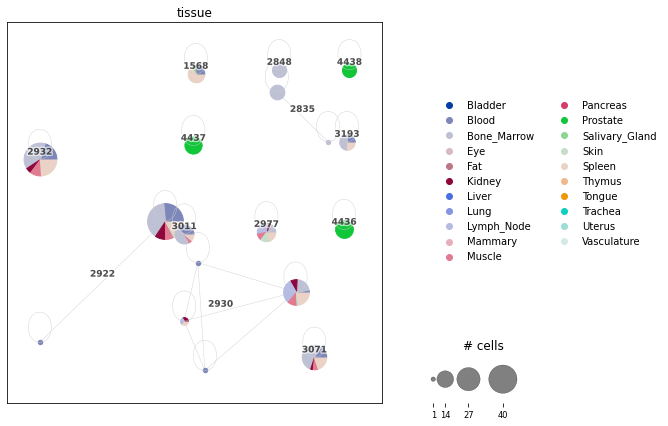

In [9]:
ir.pl.clonotype_network(
    adata, color="tissue", base_size=20, label_fontsize=9, panel_size=(7, 7)
)



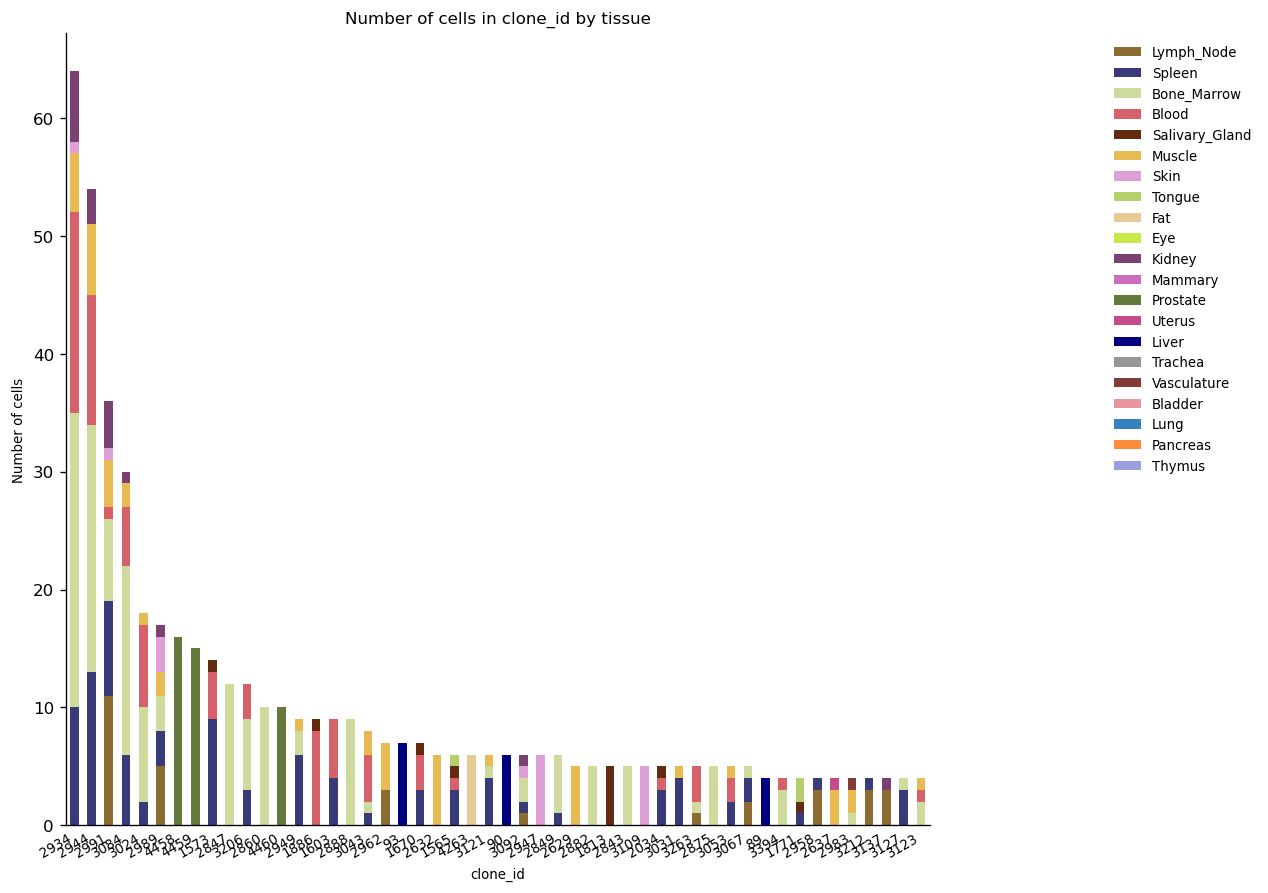

In [11]:
ax = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="tissue", max_cols=50, figsize=(12, 12), color = tissue_colors() )

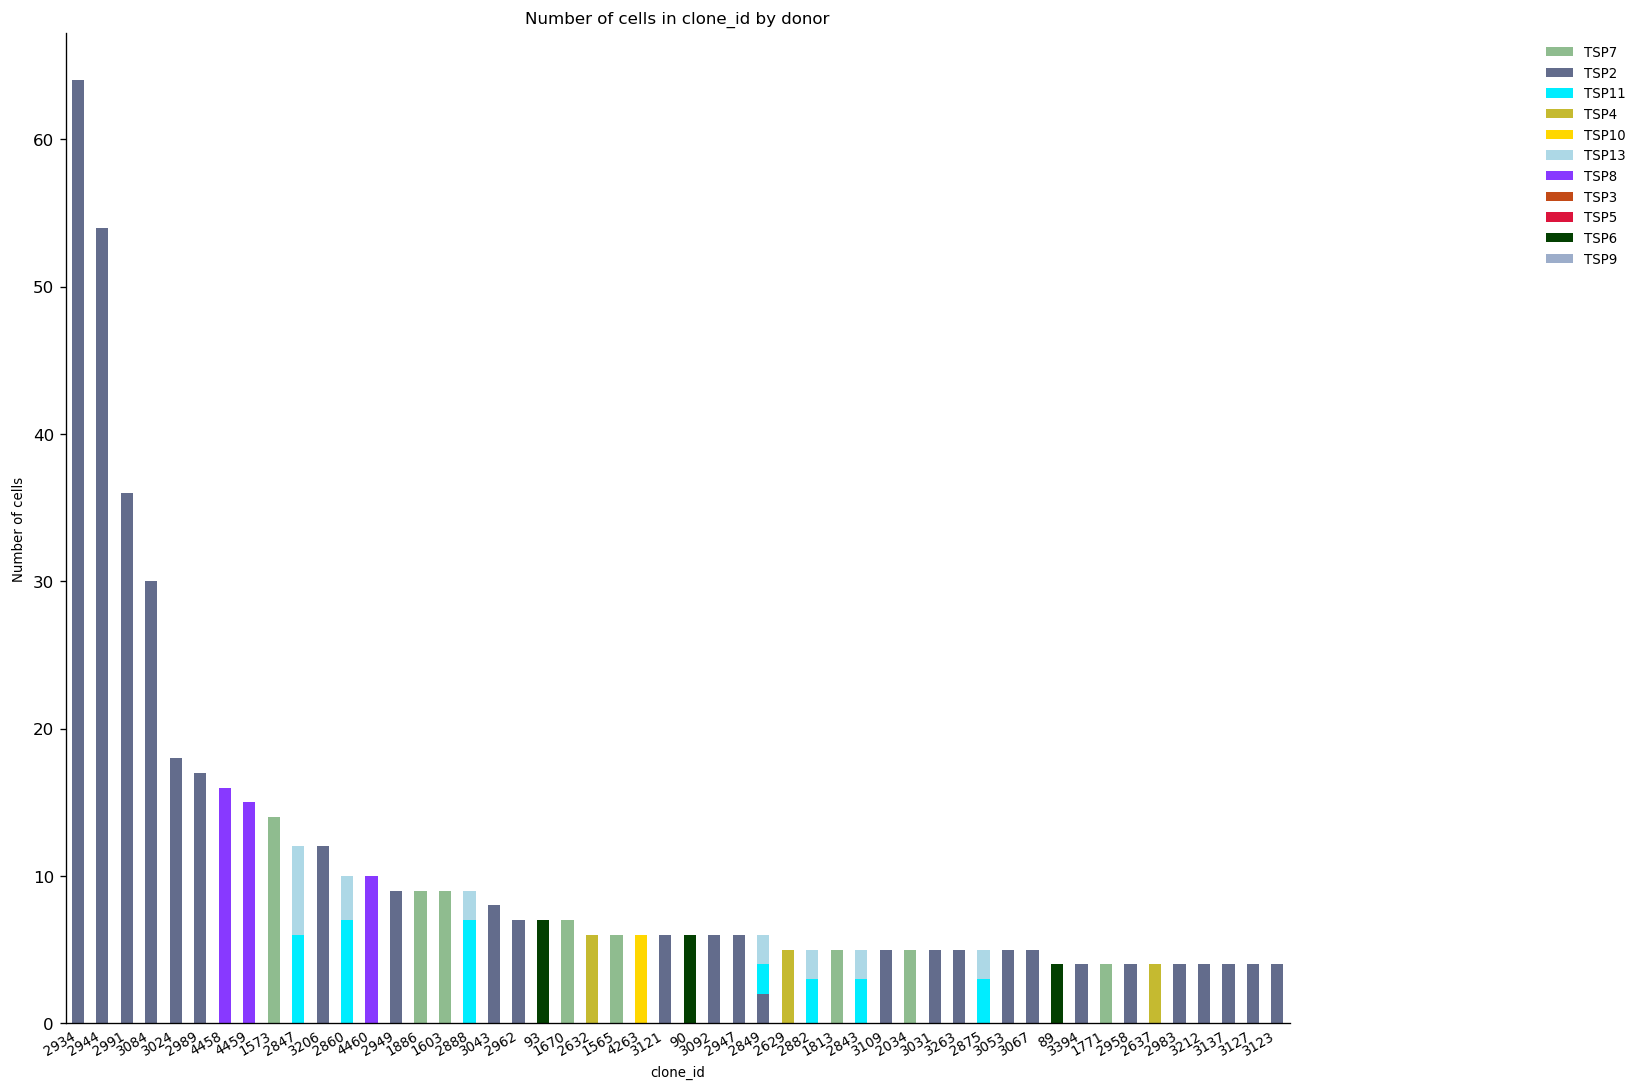

In [12]:
ax = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="donor", max_cols=50, figsize=(17, 15), color = donor_colors())

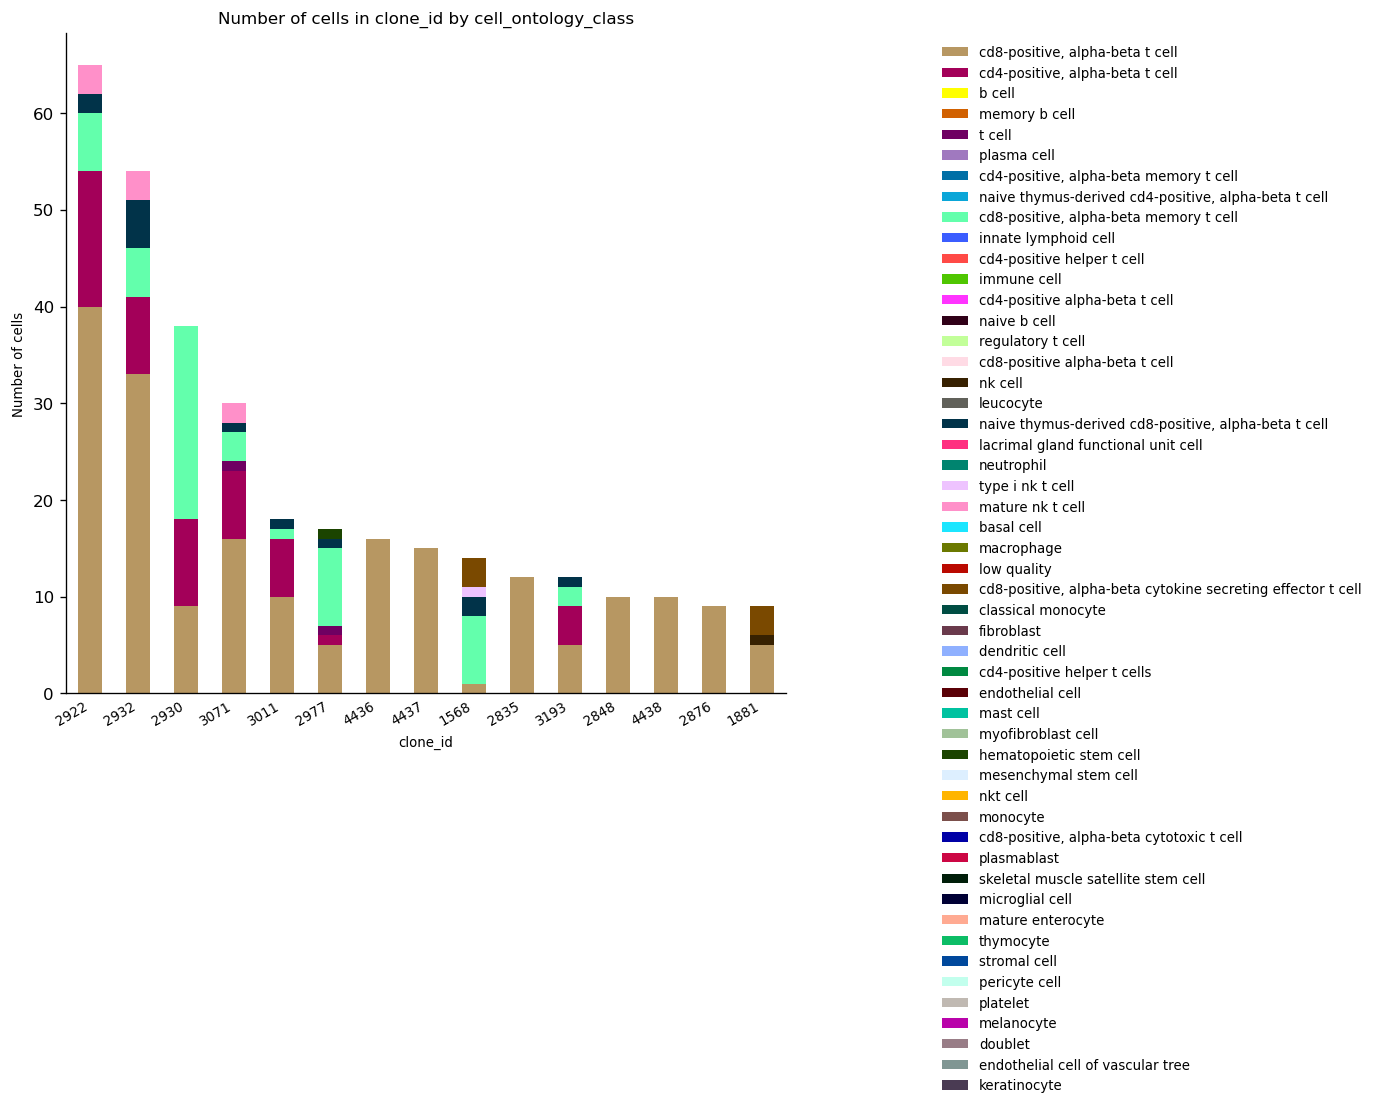

In [11]:
ax = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="cell_ontology_class", max_cols=15, figsize=(10, 10)
)